<a href="https://colab.research.google.com/github/chaurasiauttkarsh/Machine-Learning/blob/master/6_5_Data_Engineering_Knowledge_Based_Feature_Selection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Feature engineering is often an important place to use expert knowledge for a particular application. While the purpose of machine learning in many cases is to avoid having to create a set of expert-designed rules, that doesn’t mean that prior knowledge of the application or domain should be discarded. Often, domain experts can help in identifying useful features that are much more informative than the initial representation of the data. 

Imagine you work for a travel agency and want to predict flight prices. Let’s say you have a record of prices together with dates, airlines, start locations, and destinations. A machine learning model might be able to build a decent model from that. Some important factors in flight prices, however, cannot be learned. For example, flights are usually more expensive during peak vacation months and around holidays. While the dates of some holidays (like Christmas) are fixed, and their effect can therefore be learned from the date, others might depend on the phases of the moon (like Hanukkah and Easter) or be set by authorities (like school holidays). These events cannot be learned from the data if each flight is only recorded using the (Gregorian) date. However, it is easy to add a feature that encodes whether a flight was on, preceding, or following a public or school holiday. In this way, prior knowledge about the nature of the task can be encoded in the features to aid a machine learning algorithm. Adding a feature does not force a machine learning algorithm to use it, and even if the holiday information turns out to be noninformative for flight prices, augmenting the data with this information doesn’t hurt.

We’ll now look at one particular case of using expert knowledge—though in this case it might be more rightfully called “common sense.” The task is predicting bicycle rentals in front of Andreas’s house.
In New York, Citi Bike operates a network of bicycle rental stations with a subscription system. The stations are all over the city and provide a convenient way to get around. Bike rental data is made public in an anonymized form and has been analyzed in various ways. The task we want to solve is to predict for a given time and day how many people will rent a bike in front of Andreas’s house—so he knows if any bikes will be left for him.

We first load the data for August 2015 for this particular station as a pandas Data Frame. We resample the data into three-hour intervals to obtain the main trends for each day:

In [1]:
!pip install mglearn
import mglearn

     |████████████████████████████████| 542kB 7.5MB/s 
  Created wheel for mglearn: filename=mglearn-0.1.7-py2.py3-none-any.whl size=582705 sha256=643a951b1b1b795d86df04ffcded36e2f76524701b79074478edc2e4bccf3cab
  Stored in directory: /root/.cache/pip/wheels/74/cf/8d/04f4932d15854a36726c6210763c7127e62de28f5c8ddfcf3b
Successfully built mglearn


/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [0]:
citibike = mglearn.datasets.load_citibike()

In [3]:
print("Citi Bike data:\n{}".format(citibike.head()))

Citi Bike data:
starttime
2015-08-01 00:00:00     3
2015-08-01 03:00:00     0
2015-08-01 06:00:00     9
2015-08-01 09:00:00    41
2015-08-01 12:00:00    39
Freq: 3H, Name: one, dtype: int64


The following example shows a visualization of the rental frequencies for the whole month.

Text(0, 0.5, 'Rentals')

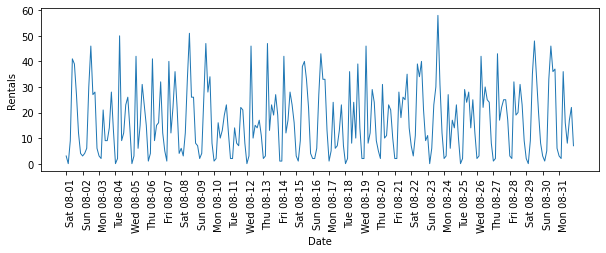

In [6]:
import matplotlib.pyplot as plt
import pandas as pd

plt.figure(figsize=(10, 3))
xticks = pd.date_range(start=citibike.index.min(), end=citibike.index.max(),freq='D')
plt.xticks(xticks, xticks.strftime("%a %m-%d"), rotation=90, ha="left")
plt.plot(citibike, linewidth=1) 
plt.xlabel("Date") 
plt.ylabel("Rentals")

We will use the first 184 data points, corresponding to the first 23 days, as our training set, and the remaining 64 data points, corresponding to the remaining 8 days, as our test set.

The only feature that we are using in our prediction task is the date and time when a particular number of rentals occurred. So, the input feature is the date and time—say, 2015-08-01 00:00:00—and the output is the number of rentals in the following three hours (three in this case, according to our DataFrame).

A (surprisingly) common way that dates are stored on computers is using POSIX time, which is the number of seconds since January 1970 00:00:00 (aka the beginning of Unix time). As a first try, we can use this single integer feature as our data repre‐ sentation:

In [0]:
 # extract the target values (number of rentals)
y = citibike.values

# convert to POSIX time by dividing by 10**9
X = citibike.index.astype("int64").values.reshape(-1, 1) // 10**9

In [0]:
# use the first 184 data points for training, and the rest for testing
n_train = 184
    # function to evaluate and plot a regressor on a given feature set
def eval_on_features(features, target, regressor):
  # split the given features into a training and a test set
  X_train, X_test = features[:n_train], features[n_train:]
  # also split the target array
  y_train, y_test = target[:n_train], target[n_train:] 
  regressor.fit(X_train, y_train)
  print("Test-set R^2: {:.2f}".format(regressor.score(X_test, y_test))) 
  y_pred = regressor.predict(X_test)
  y_pred_train = regressor.predict(X_train)
  plt.figure(figsize=(10, 3))
  plt.xticks(range(0, len(X), 8), xticks.strftime("%a %m-%d"), rotation=90, ha="left")
  plt.plot(range(n_train), y_train, label="train")
  plt.plot(range(n_train, len(y_test) + n_train), y_test, '-', label="test") 
  plt.plot(range(n_train), y_pred_train, '--', label="prediction train")
  plt.plot(range(n_train, len(y_test) + n_train), y_pred, '--', label="prediction test")
  plt.legend(loc=(1.01, 0)) 
  plt.xlabel("Date") 
  plt.ylabel("Rentals")  

Test-set R^2: -0.04


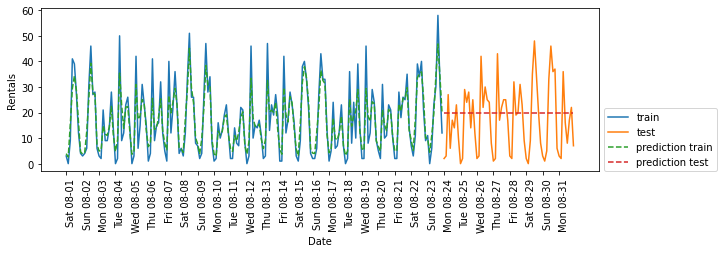

In [11]:
from sklearn.ensemble import RandomForestRegressor
regressor = RandomForestRegressor(n_estimators=100, random_state=0) 
eval_on_features(X, y, regressor)

 The R2 is –0.04, which means that we learned nothing.

From looking at the rental figures in the training data, two factors seem to be very important: the time of day and the day of the week. So, let’s add these two features. We can’t really learn anything from the POSIX time, so we drop that feature.

Test-set R^2: 0.60


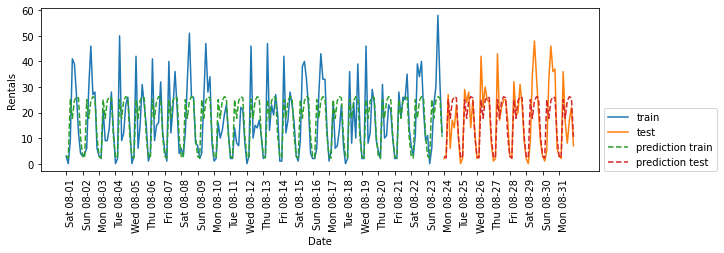

In [12]:
X_hour = citibike.index.hour.values.reshape(-1, 1) 
eval_on_features(X_hour, y, regressor)

The R2 is already much better, but the predictions clearly miss the weekly pattern.
Now let’s also add the day of the week

Test-set R^2: 0.84


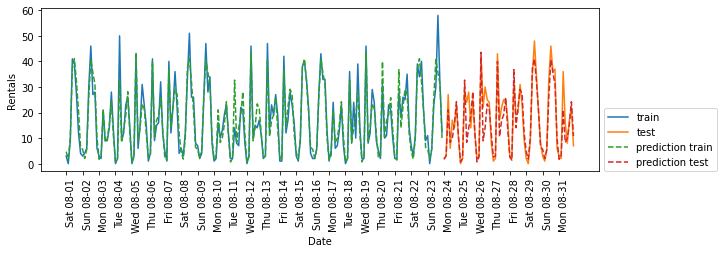

In [14]:
import numpy as np
X_hour_week = np.hstack([citibike.index.dayofweek.values.reshape(-1, 1), citibike.index.hour.values.reshape(-1, 1)])
eval_on_features(X_hour_week, y, regressor)

Now we have a model that captures the periodic behavior by considering the day of week and time of day. It has an R2 of 0.84, and shows pretty good predictive performance. What this model likely is learning is the mean number of rentals for each combination of weekday and time of day from the first 23 days of August. This actually does not require a complex model like a random forest, so let’s try with a simpler model, LinearRegression.

Test-set R^2: 0.13


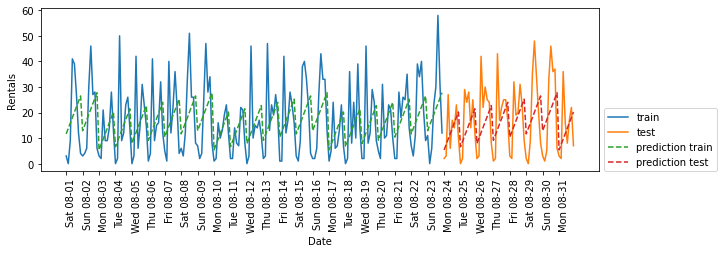

In [15]:
from sklearn.linear_model import LinearRegression 
eval_on_features(X_hour_week, y, LinearRegression())

LinearRegression works much worse, and the periodic pattern looks odd. The rea‐ son for this is that we encoded day of week and time of day using integers, which are interpreted as continuous variables. Therefore, the linear model can only learn a linear function of the time of day—and it learned that later in the day, there are more rentals. However, the patterns are much more complex than that. We can capture this by interpreting the integers as categorical variables, by transforming them using One HotEncoder.

In [0]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder()
X_hour_week_onehot = enc.fit_transform(X_hour_week).toarray()

Test-set R^2: 0.62


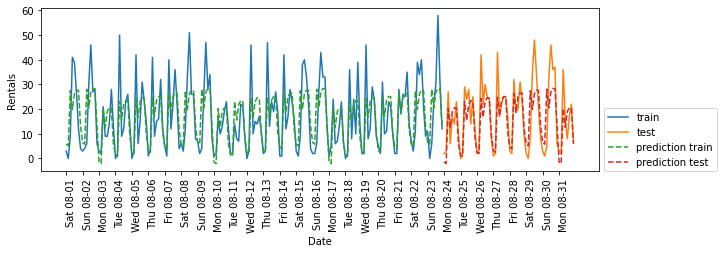

In [19]:
from sklearn.linear_model import Ridge
eval_on_features(X_hour_week_onehot, y, Ridge())

This gives us a much better match than the continuous feature encoding. Now the linear model learns one coefficient for each day of the week, and one coefficient for each time of the day. That means that the “time of day” pattern is shared over all days of the week, though.

Using interaction features, we can allow the model to learn one coefficient for each combination of day and time of day.

Test-set R^2: 0.85


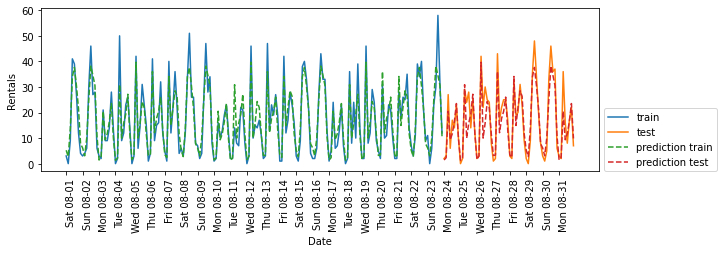

In [20]:
from sklearn.preprocessing import PolynomialFeatures
poly_transformer = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_hour_week_onehot_poly = poly_transformer.fit_transform(X_hour_week_onehot) 
lr = Ridge()
eval_on_features(X_hour_week_onehot_poly, y, lr)


This transformation finally yields a model that performs similarly well to the random forest. A big benefit of this model is that it is very clear what is learned: one coefficient for each day and time. We can simply plot the coefficients learned by the model, something that would not be possible for the random forest.

First, we create feature names for the hour and day features:

In [0]:
hour = ["%02d:00" % i for i in range(0, 24, 3)]
day = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"] 
features = day + hour

Then we name all the interaction features extracted by PolynomialFeatures, using the get_feature_names method, and keep only the features with nonzero coefficients:

In [0]:
features_poly = poly_transformer.get_feature_names(features) 
features_nonzero = np.array(features_poly)[lr.coef_ != 0] 
coef_nonzero = lr.coef_[lr.coef_ != 0]

Now we can visualize the coefficients learned by the linear model.

Text(0, 0.5, 'Feature magnitude')

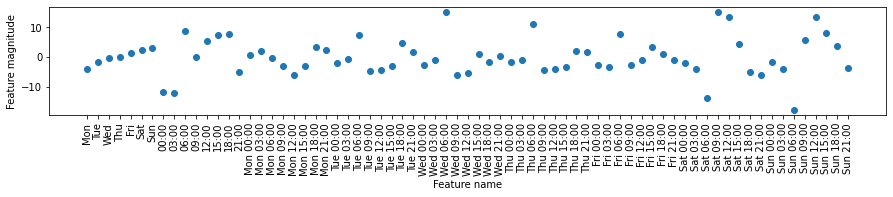

In [23]:
plt.figure(figsize=(15, 2))
plt.plot(coef_nonzero, 'o')
plt.xticks(np.arange(len(coef_nonzero)), features_nonzero, rotation=90) 
plt.xlabel("Feature name")
plt.ylabel("Feature magnitude")